In [2]:
#imports
import os
import pandas as pd
import numpy as np
from srim import Ion, Target, Layer, TRIM
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\dziubins\Anaconda3\lib\site-packages\srim\core\elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


In [5]:
def set_beam_properties(element, mass, energy, energy_spread, sigma_x, sigma_y):
    energies = np.random.normal(energy*mass,energy_spread*energy*mass,2000)*1e6
    x_pos = np.random.normal(0,sigma_x,2000) #mm
    y_pos = np.random.normal(0,sigma_y,2000) #mm
    return [element, mass, energies, x_pos, y_pos]
def run(beam, win):
    for i in range(len(beam[2])):   
        ion = Ion(beam[0], beam[2][i] , mass=beam[1])

        #construct target
        window = Layer({
            win[0]: {
                'stoich': win[1],
                'E_d': win[2],
                'lattice': win[3],
                'surface': win[4]}
            }, density=win[5], width=win[6])
        air = Layer({
            'Ar': {
                'stoich': 0.012827,
                'E_d': 5,
                'lattice': 1.0,
                'surface': 2},
            'N': {
                'stoich': 0.755267,
                'E_d': 28,
                'lattice': 3.0,
                'surface': 2},
            'C': {
                'stoich': 0.000124,
                'E_d': 28,
                'lattice': 3.0,
                'surface': 7.41},
            'O': {
                'stoich': 0.231781,
                'E_d': 28,
                'lattice': 3.0,
                'surface': 2}
            }, density=1.2048e-3, width=3e8)
        target = Target([window,air])

        #create TRIM run
        calculation = 1
        kwargs  = {"angle_ions":0, "transmit":True}
        trim = TRIM(target, ion, calculation, 2,**kwargs)
        srim_executable_directory = 'C://Users/dziubins/Desktop/SRIM'
        SRIM_Outputs = 'C://Users/dziubins/Desktop/SRIM/SRIM Outputs/{0} mm '.format(win[6]/1e7)
        results = trim.run(srim_executable_directory)

        #save ouput files
        folder = 'e23508 {0}'.format(i)
        file_directory = os.path.abspath(SRIM_Outputs + folder)
        os.makedirs(file_directory, exist_ok=True)
        TRIM.copy_output_files(srim_executable_directory, file_directory, check_srim_output= True)

In [6]:
prop = set_beam_properties('Se', 82, 150, 0.001, 1, 0.5)
win = ['Al',1.0, 25, 3.0, 3.363, 2.702, 0.5e7]
run(prop,win)

KeyboardInterrupt: 

In [8]:
import numpy as np
import os, sys, stat
import pandas as pd

case_numbers = np.arange(0,51,1)
#define directories
directory = "C://Users/dziubins/Desktop/SRIM/SRIM Outputs/"
os.chdir(directory)

a = ['Ion Num', 'Atomic Num', 'Energy(eV)', 'Depth X(A)', 'Lateral-Pos Y(A)', 
             'Lateral-Pos Z(A)', 'Dir Cos(X)', 'Dir Cos(Y)', 'Dir Cos(Z)' ]

perm = pd.DataFrame(columns=a)
for case_num in case_numbers:
    #print(case_num)
    file_name = "0.5 mm e23508 {0}/TRANSMIT.txt".format(case_num)
    strings = open(file_name).readlines()
    #print(strings[12:13])
    del strings[0:12]
    for line in range(len(strings)):
        split_ion = strings[line].split()  
        s = set(split_ion) #make s a set of cut and pslit ions\
        if 'T' in s:
            split_ion.remove('T')
        if '-' in s:
            split_ion.remove('-')
        strings[line] = [float(p) for p in split_ion]
        #print(strings[line])
    temp = pd.DataFrame(strings,columns=a)
    if case_num == 0:
        perm = temp
    else:
        perm = perm.append(temp,ignore_index=True)


In [9]:
mean = round(perm['Energy(eV)'].mean()/1e6,2)
spread = round(np.std(perm['Energy(eV)'])/1e6,2)
mean_i = round(prop[2].mean()/1e6,2)
spread_i = round(np.std(prop[2]/1e6),2)
print('----Before Al Blankoff----')
print('Average: ',mean_i,'MeV')
print('Spread: ',spread_i,'MeV')
print('Percent Spread: ', round(spread_i/mean_i*100,2), '%')
print('------At ELOSS Window-----')
print('Average: ',mean,'MeV')
print('Spread: ',spread,'MeV')
print('Percent Spread: ', round(spread/mean*100,2), '%')
print('---------Analysis---------')
print('Average Energy Loss: ', round(mean_i-mean,2), 'MeV')
print('Energy Straggling Gained from blankoff: ', round(spread-spread_i,2), 'MeV')

----Before Al Blankoff----
Average:  12299.78 MeV
Spread:  12.53 MeV
Percent Spread:  0.1 %
------At ELOSS Window-----
Average:  11621.32 MeV
Spread:  12.34 MeV
Percent Spread:  0.11 %
---------Analysis---------
Average Energy Loss:  678.46 MeV
Energy Straggling Gained from blankoff:  -0.19 MeV


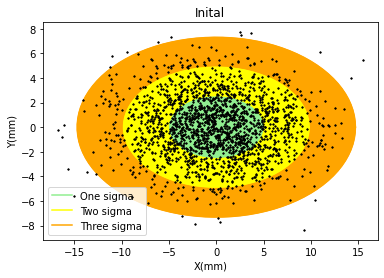

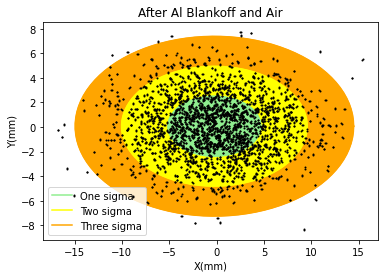

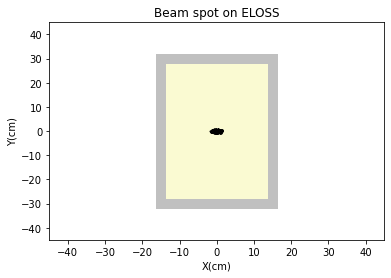

In [115]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from math import pi
z_i,y_i = np.repeat(prop[3],2),np.repeat(prop[4],2)
z,y = perm['Lateral-Pos Z(A)']/1e7,perm['Lateral-Pos Y(A)']/1e7

total_z = z+z_i #in mm
total_y = y+y_i #in mm

z0 = total_z.mean()
y0 = total_y.mean()

sigma_z = np.std(total_z)
sigma_y = np.std(total_y)
sigma_zi = np.std(z_i)
sigma_yi = np.std(y_i)

a = sigma_z
b = sigma_y

t = np.linspace(0, 2*pi, 100)

plt.figure(1)
plt.plot( sigma_zi*np.cos(t) , sigma_yi*np.sin(t),color='lightgreen',label='One sigma')
plt.fill(sigma_zi*np.cos(t), sigma_yi*np.sin(t),color='lightgreen',zorder = 4)
plt.plot( 2*sigma_zi*np.cos(t) , 2*sigma_yi*np.sin(t),color='yellow',label='Two sigma')
plt.fill( 2*sigma_zi*np.cos(t) , 2*sigma_yi*np.sin(t),color='yellow',zorder = 2)
plt.plot( 3*sigma_zi*np.cos(t) , 3*sigma_yi*np.sin(t),color='orange',label='Three sigma')
plt.fill( 3*sigma_zi*np.cos(t) , 3*sigma_yi*np.sin(t),color='orange')
plt.scatter(z_i, y_i,color='black',s=1,zorder=10)
plt.title('Inital')
plt.xlabel('X(mm)')
plt.ylabel('Y(mm)')
plt.legend()

plt.figure(2)
plt.plot( z0+a*np.cos(t) , y0+b*np.sin(t),color='lightgreen',label='One sigma')
plt.fill(z0+a*np.cos(t), y0+b*np.sin(t),color='lightgreen',zorder = 4)
plt.plot( z0+2*a*np.cos(t) , y0+2*b*np.sin(t),color='yellow',label='Two sigma')
plt.fill( z0+2*a*np.cos(t) , y0+2*b*np.sin(t),color='yellow',zorder = 2)
plt.plot( z0+3*a*np.cos(t) , y0+3*b*np.sin(t),color='orange',label='Three sigma')
plt.fill( z0+3*a*np.cos(t) , y0+3*b*np.sin(t),color='orange')
plt.scatter(total_z, total_y,color='black',s=1,zorder=10)
plt.title('After Al Blankoff and Air')
plt.xlabel('X(mm)')
plt.ylabel('Y(mm)')
plt.legend()

width = np.arange(-150,150,1)
length = np.arange(-300,300,2)
fig, ax = plt.subplots()

#create simple line plot
ax.scatter(total_z/10, total_y/10,s=1,color='black',zorder=10)

#add rectangle to plot
ax.add_patch(Rectangle((-15, -30), 30, 60,facecolor='lightgoldenrodyellow',edgecolor='silver',lw=10))

plt.xlim(-45,45)
plt.ylim(-45,45)
plt.xlabel('X(cm)')
plt.ylabel('Y(cm)')
plt.title("Beam spot on ELOSS")

#display plot
plt.show()

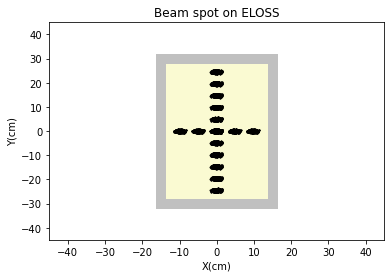

In [120]:
width = np.arange(-150,150,1)
length = np.arange(-300,300,2)
fig, ax = plt.subplots()

plt.xlim(-45,45)
plt.ylim(-45,45)
plt.xlabel('X(cm)')
plt.ylabel('Y(cm)')
plt.title("Beam spot on ELOSS")
#add rectangle to plot
ax.add_patch(Rectangle((-15, -30), 30, 60,facecolor='lightgoldenrodyellow',edgecolor='silver',lw=10))


for i in range(3):
    ax.scatter(total_z/10 + i*sigma_z, total_y/10,s=1,color='black',zorder=10)
    ax.scatter(total_z/10 - i*sigma_z, total_y/10,s=1,color='black',zorder=10)
for i in range(6):
    ax.scatter(total_z/10, total_y/10 + i*sigma_z,s=1,color='black',zorder=10)
    ax.scatter(total_z/10, total_y/10 - i*sigma_z,s=1,color='black',zorder=10)


plt.xlim(-45,45)
plt.ylim(-45,45)
plt.xlabel('X(cm)')
plt.ylabel('Y(cm)')
plt.title("Beam spot on ELOSS")

#display plot
plt.show()

In [118]:
sigma_y

2.436060010712866